In [463]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [464]:
from google.colab import files
uploaded = files.upload()

Saving tesla_data_5y.csv to tesla_data_5y (2).csv


In [465]:
df = pd.read_csv('tesla_data_5y.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [466]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df.head()

<ipython-input-466-e38766006427>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)


,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-01-19,212.19,102260300,$209.99,$213.19,$207.56
2024-01-18,211.88,108595400,$216.88,$217.45,$208.74
2024-01-17,215.55,103164400,$214.86,$215.67,$212.01
2024-01-16,219.91,115355000,$215.10,$223.49,$212.18
2024-01-12,218.89,123043800,$220.08,$225.34,$217.1501


<Axes: title={'center': 'Tesla Stocks Over the Past 5 Years'}, xlabel='Date'>

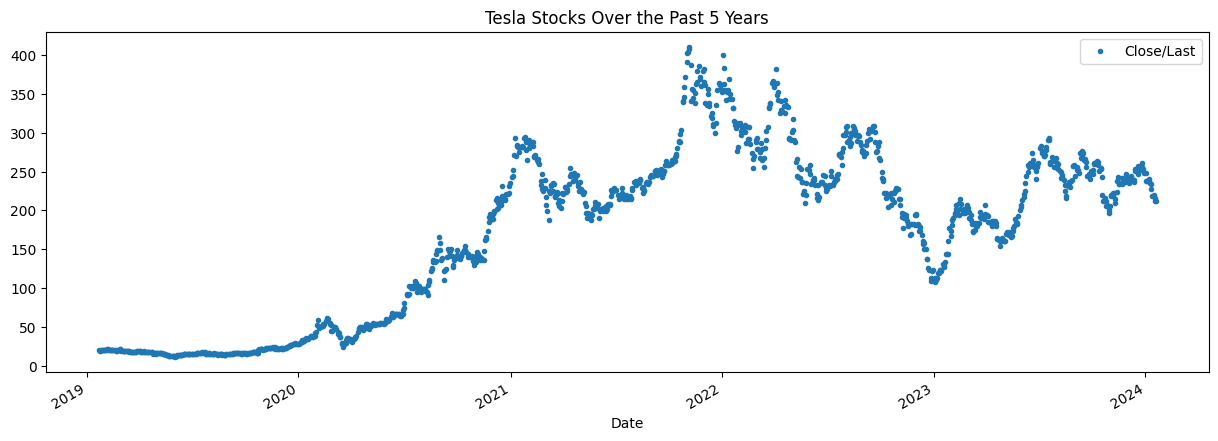

In [467]:
df.plot(style='.',
        figsize=(15,5),
        y='Close/Last',
        title='Tesla Stocks Over the Past 5 Years')

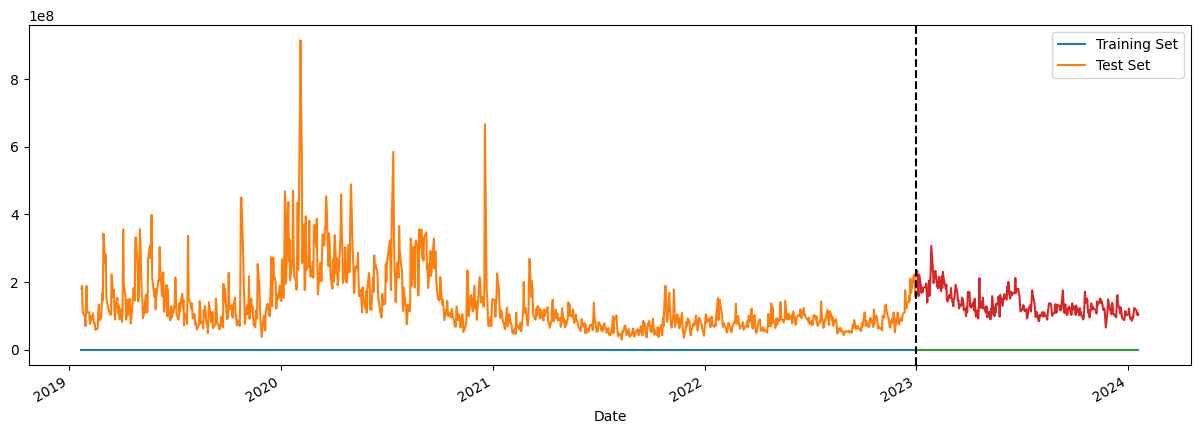

In [468]:
#Train/Test Split

train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'Tesla Stocks Over the Past Year'}, xlabel='Date'>

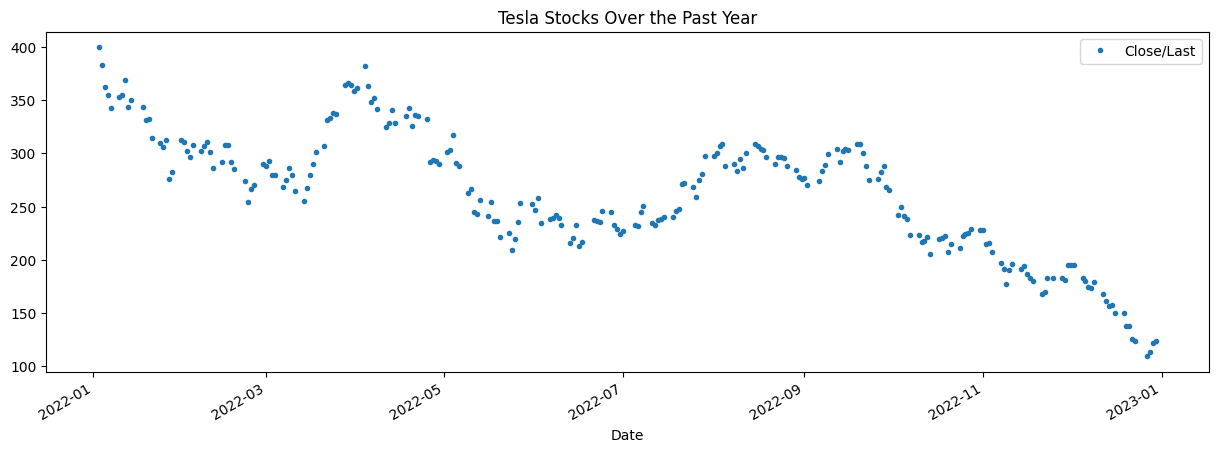

In [469]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-01-2023')].plot(
    style='.',
    figsize=(15,5),
    y = 'Close/Last',
    title='Tesla Stocks Over the Past Year')

In [470]:
#Feature Creation
def create_features(df):
  """
  Create time series features based on time series index
  """

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df

df = create_features(df)

Text(0.5, 1.0, 'Stock Price By Year')

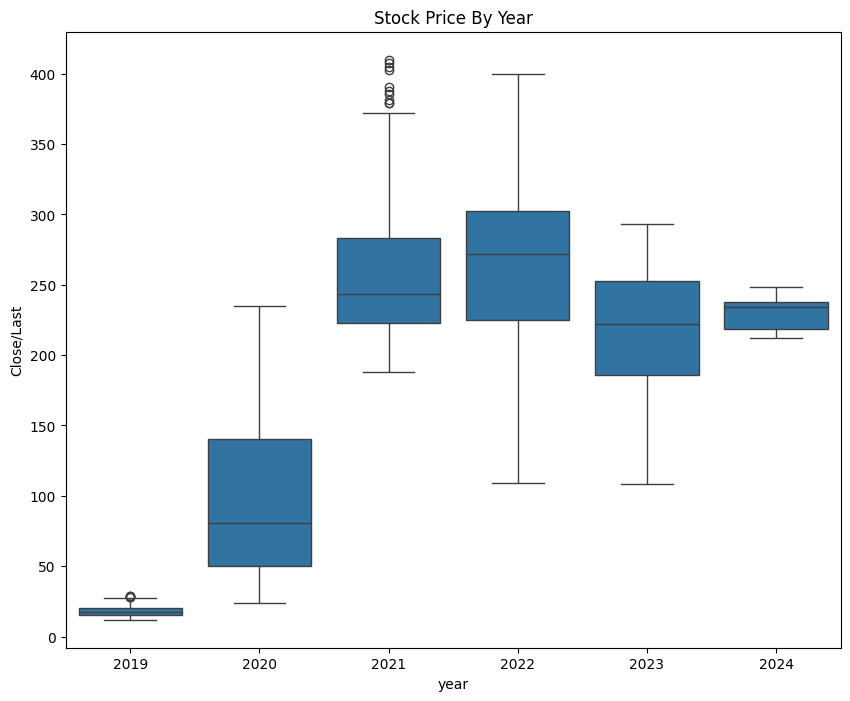

In [471]:
#visualize our feature/target relationship
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='year', y='Close/Last')
ax.set_title('Stock Price By Year')

In [474]:
# Creating Our Model
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek','quarter', 'month', 'year', 'dayofyear']
TARGETS = 'Close/Last'

X_train = train[FEATURES]
y_train = train[TARGETS]

X_test = test[FEATURES]
y_test = test[TARGETS]

In [475]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate = 0.001)

#we change the learning rate when we want to avoid overfitting

reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:115.85672	validation_1-rmse:70.04849
[1]	validation_0-rmse:115.74434	validation_1-rmse:69.98108
[2]	validation_0-rmse:115.63207	validation_1-rmse:69.91385
[3]	validation_0-rmse:115.51991	validation_1-rmse:69.84681
[4]	validation_0-rmse:115.40787	validation_1-rmse:69.77996
[5]	validation_0-rmse:115.29593	validation_1-rmse:69.71329
[6]	validation_0-rmse:115.18411	validation_1-rmse:69.64681
[7]	validation_0-rmse:115.07241	validation_1-rmse:69.58052
[8]	validation_0-rmse:114.96081	validation_1-rmse:69.51441
[9]	validation_0-rmse:114.84932	validation_1-rmse:69.44849
[10]	validation_0-rmse:114.73794	validation_1-rmse:69.38276
[11]	validation_0-rmse:114.62668	validation_1-rmse:69.31722
[12]	validation_0-rmse:114.51553	validation_1-rmse:69.25186
[13]	validation_0-rmse:114.40449	validation_1-rmse:69.18669
[14]	validation_0-rmse:114.29355	validation_1-rmse:69.12171
[15]	validation_0-rmse:114.18273	validation_1-rmse:69.05691
[16]	validation_0-rmse:114.07203	validation_1-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

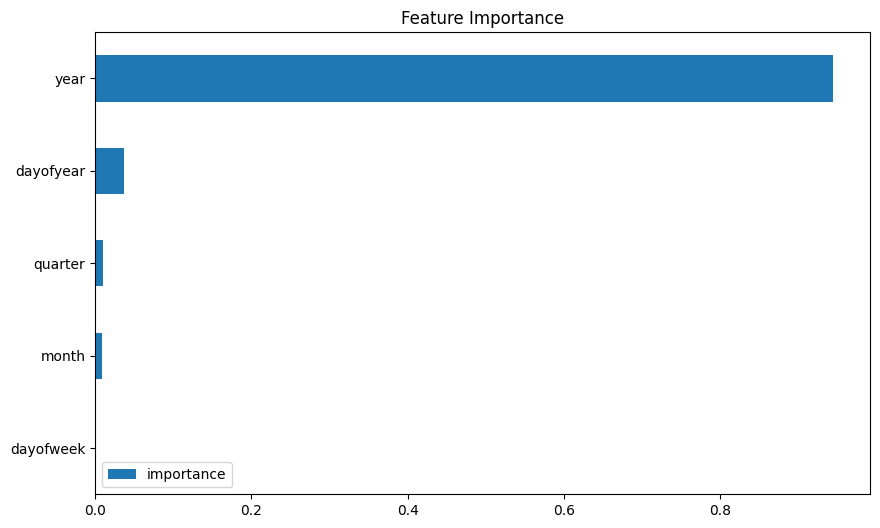

In [476]:
#feature importance
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

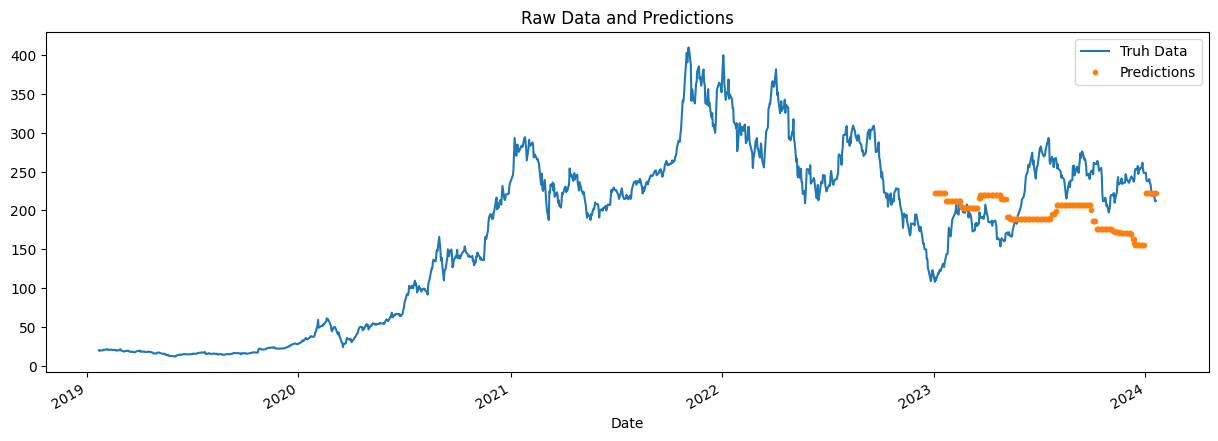

In [477]:
#forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Close/Last']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truh Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


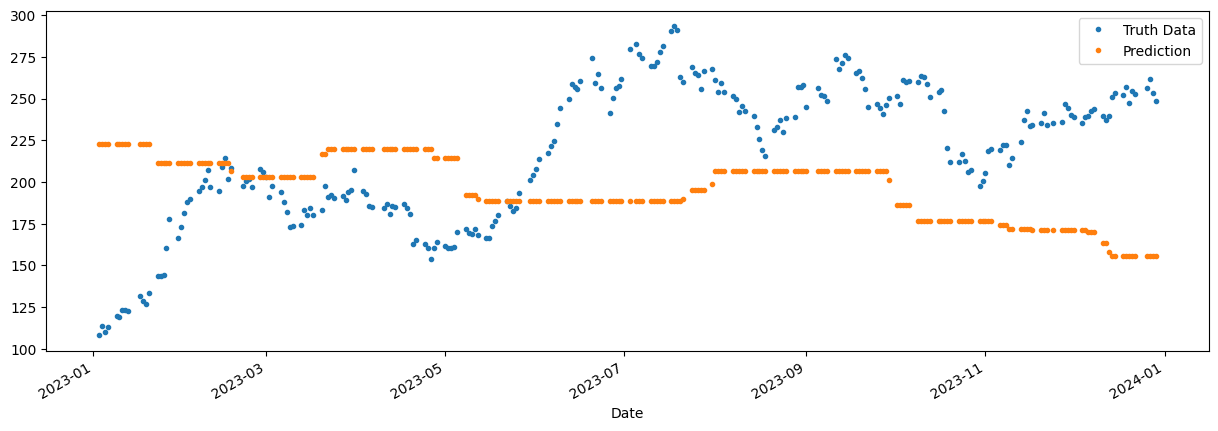

In [478]:
ax = df.loc[(df.index > '01-01-2023') & (df.index < '01-01-2024')]['Close/Last'].plot(
    style='.',
    figsize=(15,5))

df.loc[(df.index > '01-01-2023') & (df.index < '01-01-2024')]['prediction'].plot(
    style='.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [479]:
score = np.sqrt(mean_squared_error(test['Close/Last'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 56.54


In [480]:
#Calculating Error
test['error'] = np.abs(test[TARGETS] - test['prediction'])

In [481]:
test['date'] = test.index.date

In [482]:
#These are the worst prediction because they have the highest error
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2023-01-03    114.369543
2023-01-05    112.129543
2023-01-06    109.409543
2023-01-04    108.829543
2023-12-27    106.077207
Name: error, dtype: float64